In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Dissertation/dataset.xlsx")

Mounted at /content/drive


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

In [ ]:
# Drop less relevant features
df.drop(["OperatingSystems", "Browser", "Region", "TrafficType"], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  VisitorType              12330 non-null  object 
 12  Weekend                  12330 non-null  bool   
 13  Revenue                  12330 non-null  bool   
dtypes: bool(2), float64(7)

In [ ]:
# One-Hot Encoding for categorical features

# Convert "Month" column to categorical and One-Hot Encode properly
df["Month"] = df["Month"].astype(str)  # Ensure it's a string
month_dummies = pd.get_dummies(df["Month"], prefix="Month")  # One-Hot Encode

# Drop the original "Month" column and replace it with one-hot encoded columns
df = pd.concat([df.drop("Month", axis=1), month_dummies], axis=1)


In [ ]:
df = pd.get_dummies(df, columns=["VisitorType"], drop_first=False)


In [ ]:
df.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  int64  
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  int64  
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  int64  
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  Weekend                        12330 non-null  bool   
 11  Revenue                        12330 non-null  bool   
 12  Month_Aug                      12330 non-null 

In [ ]:
# Convert boolean
df["Weekend"] = df["Weekend"].astype(int)
df["Revenue"] = df["Revenue"].astype(int)

# Log transformation for skewed features
skewed_features = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "PageValues"]
df[skewed_features] = df[skewed_features].apply(lambda x: np.log1p(x))

In [ ]:
# Define feature set and target variable
X = df.drop("Revenue", axis=1)
y = df["Revenue"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Standardize numerical features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models with hyperparameter tuning for Random Forest , XGBOOST and SVM , to fine-tune models for better accuracy.
param_grid_rf = {"n_estimators": [100, 200], "max_depth": [10, 20], "min_samples_split": [2, 5]}
param_grid_xgb = {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1]}
param_grid_svm = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='accuracy'),
    "XGBoost": GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), param_grid_xgb, cv=3, scoring='accuracy'),
    "SVM": GridSearchCV(SVC(probability=True), param_grid_svm, cv=3, scoring='accuracy')
}


In [ ]:
# Train models and evaluate performance
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results.append([name, accuracy, precision, recall, f1, roc_auc])

# Convert results into DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])
print("\nModel Performance Comparison:\n")
print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Model Performance Comparison:

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.905253   0.929771  0.876679  0.902445  0.966250
1        Decision Tree  0.899256   0.909046  0.887236  0.898009  0.899172
2        Random Forest  0.929000   0.920904  0.938580  0.929658  0.981598
3              XGBoost  0.925402   0.925180  0.925624  0.925402  0.980327
4                  SVM  0.916047   0.921693  0.909309  0.915459  0.970805


In [ ]:
pip install scikit-learn --upgrade

<ipython-input-14-c718cde8b501>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="coolwarm", edgecolor='black')


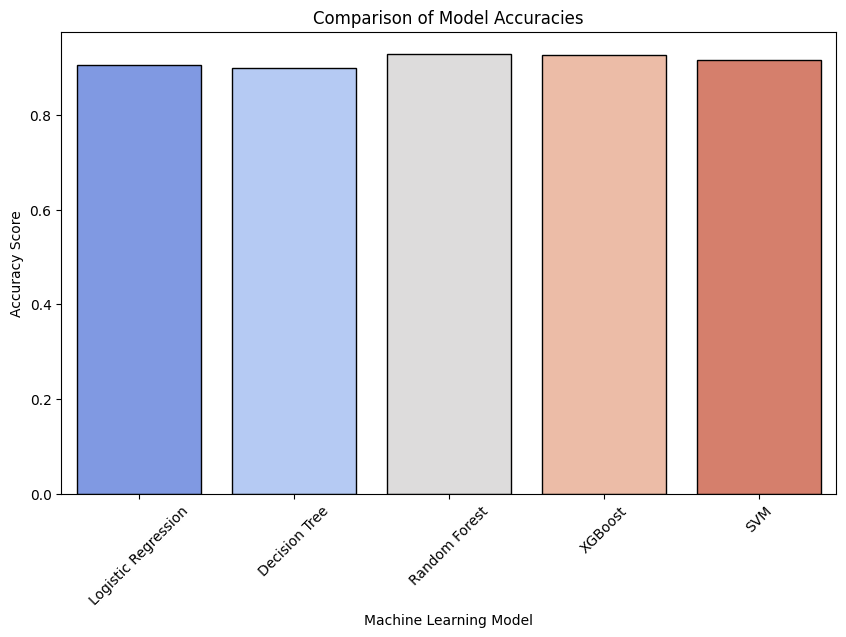

In [ ]:
# Visualize Model Performance
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="coolwarm", edgecolor='black')
plt.xlabel("Machine Learning Model")
plt.ylabel("Accuracy Score")
plt.title("Comparison of Model Accuracies")
plt.xticks(rotation=0)
plt.show()


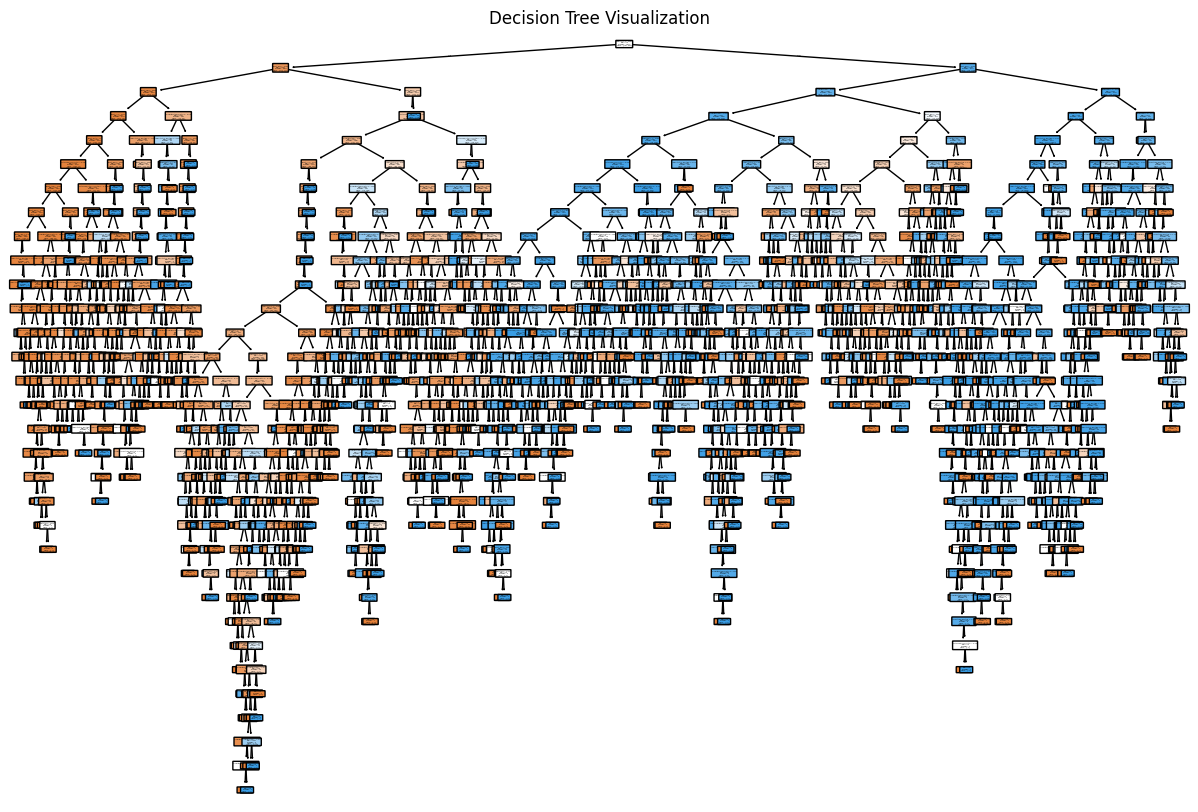

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

decision_tree = models["Decision Tree"]

# Plot the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(decision_tree, feature_names=X.columns, class_names=["No Purchase", "Purchase"], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()



📊 Feature Importance in Random Forest:
                          Feature  Importance
8                      PageValues    0.429533
7                       ExitRates    0.094089
5         ProductRelated_Duration    0.076212
18                      Month_Nov    0.063180
4                  ProductRelated    0.062424
6                     BounceRates    0.052637
1         Administrative_Duration    0.043207
0                  Administrative    0.031380
21        VisitorType_New_Visitor    0.025062
3          Informational_Duration    0.018543
23  VisitorType_Returning_Visitor    0.012813
2                   Informational    0.012245
10                        Weekend    0.011598
17                      Month_May    0.009834
12                      Month_Dec    0.009794
19                      Month_Oct    0.009356
16                      Month_Mar    0.008111
20                      Month_Sep    0.007293
14                      Month_Jul    0.007007
9                      SpecialDay    0.0

<ipython-input-16-3204d529345d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")


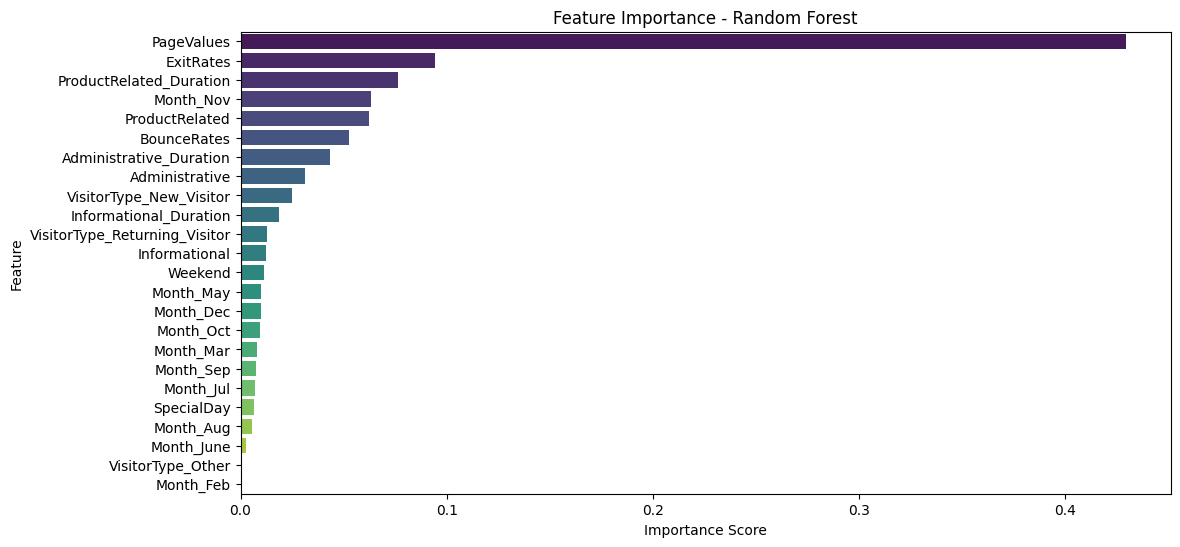

In [ ]:
# Get trained Random Forest model
rf_model = models["Random Forest"].best_estimator_


feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Feature Importance in Random Forest:")
print(feature_importances)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.show()


In [ ]:
import pickle
with open("random_forest_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)


CHECKING HOW NEW CUSTOMERS INFO WILL BE PREDICTED

In [ ]:

feature_names = X.columns

# Define the new customer's data
new_customer = pd.DataFrame([{
    "Administrative_Duration": 10,
    "Informational_Duration": 5,
    "ProductRelated_Duration": 100,
    "BounceRates": 0.02,
    "ExitRates": 0.05,
    "PageValues": 50,
    "SpecialDay": 0.2,
    "Weekend": 1,
    "VisitorType": 1,
    "Month_Aug": 0, "Month_Dec": 1, "Month_Feb": 0, "Month_Jul": 0, "Month_June": 0, "Month_Mar": 0  # Ensure all months are included
}])


for col in feature_names:
    if col not in new_customer.columns:
        new_customer[col] = 0

new_customer = new_customer[feature_names]

skewed_features = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "PageValues"]
new_customer[skewed_features] = new_customer[skewed_features].apply(lambda x: np.log1p(x))

new_customer_scaled = scaler.transform(new_customer)

# Predict purchase probability
purchase_prob = best_model.predict_proba(new_customer_scaled)[:, 1]
purchase_prediction = (purchase_prob > 0.5).astype(int)

 Print Results
print(f" Purchase Probability: {purchase_prob[0]:.2f}")
print(f"Predicted Outcome: {'Will Purchase' if purchase_prediction[0] == 1 else 'Will NOT Purchase'}")


🛒 Purchase Probability: 0.72
✅ Predicted Outcome: Will Purchase


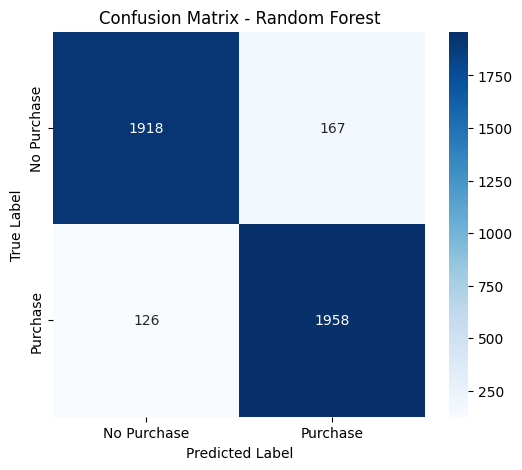

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Choose a model for evaluation
selected_model_name = "Random Forest"  # Change to "Logistic Regression", "Decision Tree", "XGBoost", "SVM"
selected_model = models[selected_model_name].best_estimator_

#Get predictions on the test set
y_test_pred = selected_model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Purchase", "Purchase"], yticklabels=["No Purchase", "Purchase"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {selected_model_name}")
plt.show()


In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Save Trained Models and Scaler
def save_models():
    with open("random_forest_model.pkl", "wb") as model_file:
        pickle.dump(models["Random Forest"].best_estimator_, model_file)

    with open("xgboost_model.pkl", "wb") as model_file:
        pickle.dump(models["XGBoost"].best_estimator_, model_file)

    with open("svm_model.pkl", "wb") as model_file:
        pickle.dump(models["SVM"].best_estimator_, model_file)

    with open("scaler.pkl", "wb") as scaler_file:
        pickle.dump(scaler, scaler_file)

    print("Models and Scaler Saved Successfully!")


# Save Model Performance Results
def save_results():
    results_df.to_csv("model_performance_results.csv", index=False)
    print("Model Performance Results Saved!")


# Save Confusion Matrix Visualization
def save_confusion_matrix(selected_model_name):
    selected_model = models[selected_model_name].best_estimator_
    y_test_pred = selected_model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Purchase", "Purchase"], yticklabels=["No Purchase", "Purchase"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {selected_model_name}")
    plt.savefig(f"confusion_matrix_{selected_model_name}.png")
    plt.close()

    print(f"Confusion Matrix for {selected_model_name} Saved as Image!")


def load_models():
    global loaded_rf_model, loaded_xgb_model, loaded_svm_model, loaded_scaler

    with open("random_forest_model.pkl", "rb") as model_file:
        loaded_rf_model = pickle.load(model_file)

    with open("xgboost_model.pkl", "rb") as model_file:
        loaded_xgb_model = pickle.load(model_file)

    with open("svm_model.pkl", "rb") as model_file:
        loaded_svm_model = pickle.load(model_file)

    with open("scaler.pkl", "rb") as scaler_file:
        loaded_scaler = pickle.load(scaler_file)

    print( "Models and Scaler Loaded Successfully!")




✅ Models and Scaler Saved Successfully!
✅ Model Performance Results Saved!
✅ Confusion Matrix for Random Forest Saved as Image!
✅ Confusion Matrix for XGBoost Saved as Image!
✅ Confusion Matrix for SVM Saved as Image!
✅ All models, results, and confusion matrices saved!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#  Convert scaled data back
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


selected_features = ["ProductRelated_Duration", "PageValues", "BounceRates", "ExitRates"]

# Plot distribution comparisons for each feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, feature in zip(axes.flatten(), selected_features):
    sns.kdeplot(X_train_df[feature], label="Train", shade=True, ax=ax)
    sns.kdeplot(X_test_df[feature], label="Test", shade=True, ax=ax)
    ax.set_title(f"Distribution of {feature} (Train vs Test)")
    ax.legend()

plt.tight_layout()
plt.show()
